In [1]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from utils.patch_utils import _get_patches
from utils.get_embds import get_embeddings
from utils.queues import Embedding_Queues
from utils.datasets_PASCAL_findContours import PascalVOCDataset

In [2]:
patch_size = 14
contrastie_weigth = "0.5"
img_size = 224
batch_size = 16
num_classes = 2

voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

dataset_path = '/home/S312112021/dataset/0_data_dataset_voc_950_kidney'
output_dir ='dataset/splits/kidney'
# model_path = f"output/{patch_size}-{contrastie_weigth}/model_supervised-Pretraining_50-s.pth"
# model_path = f"output/{patch_size}-{contrastie_weigth}/model_supervised-Pretraining_100-s.pth"
model_path = f"output/{patch_size}-{contrastie_weigth}/model_SSL-reliable-st1_100-s.pth"

In [3]:
val_dataset = PascalVOCDataset(txt_file=output_dir + "/val.txt", image_size=img_size, root_dir=dataset_path, labeled=True, colormap=voc_mask_color_map)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print('number of val_dataset: ', len(val_dataset))

number of val_dataset:  95


In [4]:
device = torch.device('cuda:0')

model = torch.load(model_path)
model = model.eval()

model.module.contrast = False

In [6]:
background_embedding_list = []
class1_embedding_list = []

# 提取 embeddings
with torch.no_grad():
    for imgs, masks in tqdm(val_loader):
        patch_list = _get_patches(
            imgs, masks,
            classes=num_classes,
            background=True,
            img_size=img_size,
            patch_size=patch_size
        )
        
        qualified_tensor_patch_list = [torch.tensor(patch) if patch is not None else None for patch in patch_list]
        emb_list = get_embeddings(model, qualified_tensor_patch_list, True, batch_size)
        
        # 處理 background_embeddings
        for emb in emb_list[0]:
            if emb is not None:  # 確保 emb 不是 None
                background_embeddings_np = emb.cpu().numpy()  # 確保從 GPU 到 CPU
                background_embeddings_np = background_embeddings_np.reshape(background_embeddings_np.shape[0], -1)
                background_embedding_list.append(background_embeddings_np)
            
        # 處理 class1_embeddings
        for emb in emb_list[1]:
            if emb is not None:  # 確保 emb 不是 None
                class1_embeddings_np = emb.cpu().numpy()  # 確保從 GPU 到 CPU
                class1_embeddings_np = class1_embeddings_np.reshape(class1_embeddings_np.shape[0], -1)
                class1_embedding_list.append(class1_embeddings_np)

100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


In [10]:
# 合併 embeddings 列表
background_embeddings = np.concatenate(background_embedding_list)
class1_embeddings = np.concatenate(class1_embedding_list)

# 確保 embeddings 是2D數組
background_embeddings = background_embeddings.reshape(background_embeddings.shape[0], -1)
class1_embeddings = class1_embeddings.reshape(class1_embeddings.shape[0], -1)

# # 降維
# tsne = TSNE(n_components=2, perplexity=30, learning_rate=100)
# background_embeddings_2d = tsne.fit_transform(background_embeddings)
# class1_embeddings_2d = tsne.fit_transform(class1_embeddings)

/home/S312112021/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


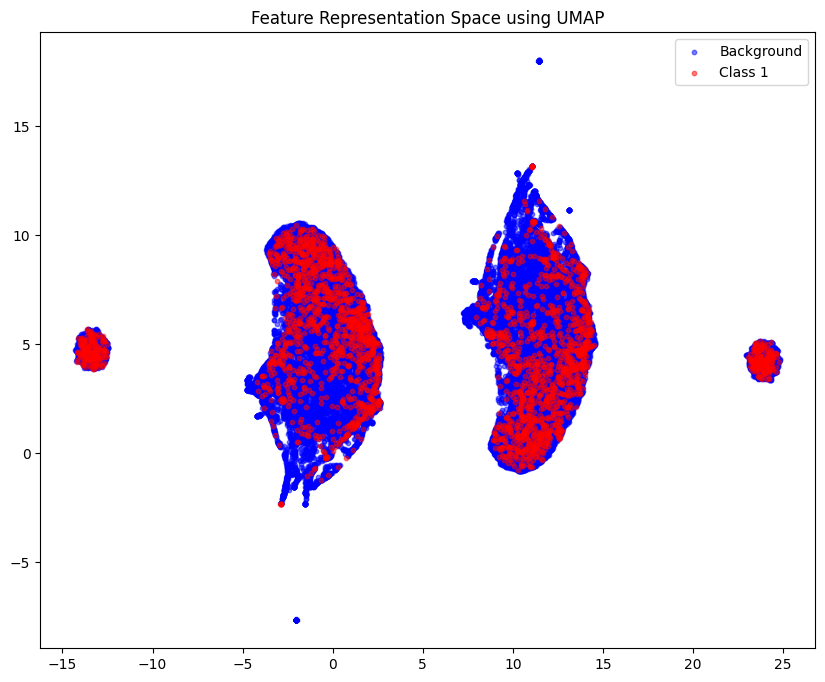

In [11]:
# 使用 UMAP 进行降维
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
combined_embeddings = np.concatenate((background_embeddings, class1_embeddings))
combined_embeddings_2d = reducer.fit_transform(combined_embeddings)

# 分离降维后的背景和类1的嵌入
background_embeddings_2d = combined_embeddings_2d[:background_embeddings.shape[0]]
class1_embeddings_2d = combined_embeddings_2d[background_embeddings.shape[0]:]

# 绘制表示空间
plt.figure(figsize=(10, 8))
plt.scatter(background_embeddings_2d[:, 0], background_embeddings_2d[:, 1], c='blue', label='Background', alpha=0.5, s=10)
plt.scatter(class1_embeddings_2d[:, 0], class1_embeddings_2d[:, 1], c='red', label='Class 1', alpha=0.5, s=10)
plt.legend()
plt.title('Feature Representation Space using UMAP')
plt.show()